In [1]:
##############################
# Author: Jacob van de Lindt
# Date:   Sep 10, 2024
# MIT PSFC
##############################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib import ticker, cm 
import os, sys
import netCDF4

In [2]:
# Setting up the paths to the local directory
# abspath = os.path.abspath('')
# dname = os.path.dirname(abspath)
# print(abspath)
# os.chdir(dname)
wkdir = os.getcwdb()

In [3]:
# Loading up the netcdf4 datasets
remoteDirectory = open(f'../../../../remoteDirectory.txt', 'r').readlines()[0].strip()
print('You are using remoteDirectory = ', remoteDirectory)
shotNum = remoteDirectory.split('/')[-1].split('_')[1]

scan_var_array = np.array([1,2,3,4,5,6,7,8,9,10,11]) # np.array([1,2,3,4,5,6,7,8,9,10,11])  #  the values of the scan TODO replace here 
scan_var_type = r'n$_{||}$ ' # type of scan with units  

# set up the lists holding the cql objects 
cql_nc_array = []
cqlrf_nc_array = []

# load up the cql objects 
for npar in scan_var_array:
    cql_nc_array += [netCDF4.Dataset(f'cql3d_npar_{npar}.nc','r')]
    cqlrf_nc_array += [netCDF4.Dataset(f'cql3d_krf_npar_{npar}.nc','r')]

# # TODO delete this over write 
# cql_nc_array[3] = netCDF4.Dataset(f'cql3d_npar_4_yuri_edits.nc','r')
# cqlrf_nc_array[3] = netCDF4.Dataset(f'cql3d_krf_npar_4_yuri_edits.nc','r')

You are using remoteDirectory =  ~/HFW_147634


In [4]:
# Get particle properties, for now assume they all have same mesh points 

# they are the same. Set a variable that is not dependent on beam energy. 
rya_list = [0]*scan_var_array.shape[0]
for i in range(scan_var_array.shape[0]):    
    rya_list[i] = cql_nc_array[i].variables["rya"][:]

#pitch angles mesh at which f is defined in radians.
#Note that np.ma.getdata pulls data through mask which
# rejects bad data (NAN, etc)

# all are equal. set just one pitch angle mesh 
pitchAngleMesh_list = [0]*scan_var_array.shape[0]
for i in range(scan_var_array.shape[0]):
    pitchAngleMesh_list[i] = np.ma.getdata(cql_nc_array[i].variables["y"][:]) 


#normalized speed mesh of f

# independent of beam energy. Set one value 
normalizedVel_list = [0]*scan_var_array.shape[0]
for i in range(scan_var_array.shape[0]):
    normalizedVel_list[i] = cql_nc_array[i].variables["x"][:]


#print(normalizedVel.shape)

#energy  = restmkev*(gamma-1)
#energies corresponding to velocities jx 
enerkev_list = [0]*scan_var_array.shape[0]
for i in range(scan_var_array.shape[0]):
    enerkev_list[i] = cql_nc_array[i].variables["enerkev"][:]


#flux surface average energy per particle in keV 

energy_list = [0]*scan_var_array.shape[0]
for i in range(scan_var_array.shape[0]):
    energy_list[i] = cql_nc_array[i].variables["energy"][:]


4
(2, 55, 500, 240)
(500,)


<ipython-input-5-21acf043ea6f>:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T + 1))#np.log(f_at_rho.T+1))


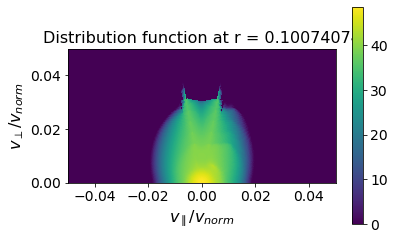

5


In [5]:
# distrobution function 
#distribution function (lrz, jx, iy)
#vnorm^3*s^3/cm^6

f_array = np.zeros_like(scan_var_array).tolist()
for i in range(scan_var_array.shape[0]):
    f_array[i] = cql_nc_array[i].variables["f"][:]
f_index = np.where(scan_var_array == 5)[0][0]
print(f_index)
f = f_array[f_index]
cql_nc = cql_nc_array[f_index]
ebkev = 80 # kev TODO: make sure this matches the file!! 

print(f.shape)
print(enerkev_list[f_index].shape)

## Plot the distrobution function at a particular rho
rho = 0.1 #0.25
i_rho = np.argmin(np.abs(rho - rya_list[f_index]))

f_at_rho = f[0, i_rho, :, :]

pitchAngles = pitchAngleMesh_list[f_index][i_rho,:]
x = cql_nc.variables["x"][:]

V, Theta = np.meshgrid(x, pitchAngles)
VPARA = V*np.cos(Theta); VPERP = V*np.sin(Theta)

plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('axes', labelsize = 16)
plt.rc('axes', titlesize = 16)
plt.rc('figure', titlesize = 18)
plt.rc('legend', fontsize = 14)
fig,ax = plt.subplots()
pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T + 1))#np.log(f_at_rho.T+1))
#ax.contourf(VPARA, VPERP, np.log(relevantF.T), cmap=cm.PuBu_r, levels = 100)
ax.set_aspect('equal')
ax.set_xlabel("$v_\parallel / v_{norm}$")
ax.set_ylabel("$v_\perp / v_{norm}$")
ax.set_ylim([0,0.05]); ax.set_xlim([-0.05,0.05])
ax.set_title(f'Distribution function at r = {rya_list[f_index][i_rho]}')
fig.colorbar(pc)
plt.show()
print(i_rho)

In [6]:
# Build the plot of energetic particles for a particular distrobution 

minEnergy = 2 # minimum energy for plotting

#index of that minimum energy in enerkev
#this index is also the index for the corresponding velocity
minEnergyIndex = np.where(enerkev_list[f_index] < minEnergy)[0][-1]
#distribution function for energetic particles
energeticF = f[0, :,minEnergyIndex:,:]#f[0, :,minEnergyIndex:,:]

# begin integrating over velocity space 
energeticF_integOverPitch = np.zeros((len(rya_list[f_index]), len(enerkev_list[f_index][minEnergyIndex:])))

# loop over r/a. At each r/a, integrate over all pitch angle. 
for rhoIndex in range(len(rya_list[f_index])):
    #this is the angular part of the spherical jacobian
    integOverPitch = 2*np.pi*np.trapz(energeticF[rhoIndex,:]*np.sin(pitchAngleMesh_list[f_index][rhoIndex]), pitchAngleMesh_list[f_index][rhoIndex], axis = 1)
    energeticF_integOverPitch[rhoIndex,:] = integOverPitch
    
print('REMEBER: check you selected the correct f from above cell')

REMEBER: check you selected the correct f from above cell


In [7]:
relevantEnergies = enerkev_list[f_index][minEnergyIndex:]
relevantVels = normalizedVel_list[f_index][minEnergyIndex:]
energeticDensity = np.zeros((len(rya_list[f_index]), len(relevantEnergies)-1))
#the energies at which the values of energeticDensity are centered
energyCenters = (relevantEnergies[1:] + relevantEnergies[:-1])/2
#We calculate energy centers by integrating up to the velocity mesh point on either side of the corresponding energyCenter point
#we then take the differences, which is the area in the bin between these two edges
for velIndex in range(len(relevantVels)-1):
    #this is the radial part of the spherical jacobian
    densityLower = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex]*relevantVels[:velIndex]**2,
        relevantVels[:velIndex]))
    densityUpper = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex+1]*relevantVels[:velIndex+1]**2,
        relevantVels[:velIndex+1]))

    if velIndex == 0:
        energeticDensity[:,velIndex] = densityUpper
        continue

    diff = densityUpper - densityLower

    energeticDensity[:,velIndex] = diff

energeticDensity = energeticDensity*1e6#convert to m^(-3)
energeticDensity = energeticDensity.astype('float64')
rya = rya_list[f_index].astype('float64')



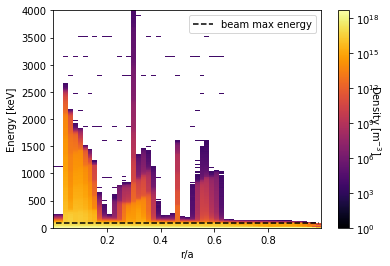

In [8]:
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('axes', titlesize = 10)
plt.rc('figure', titlesize = 10)
plt.rc('legend', fontsize = 10)
#"""
fig, ax = plt.subplots()
# pcm = ax.pcolormesh(energyCenters, rya, energeticDensity, 
#                 norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity)),
#                 shading = 'nearest')
# print('---')
# print(rya.shape)
pcm = ax.pcolormesh(rya.T, energyCenters.T, energeticDensity.T, 
                norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity.T)),
                shading = 'nearest', cmap='inferno')

cbar = fig.colorbar(pcm, ax=ax)#, extend='max')
cbar.set_label(r'Density [m$^{-3}$]', rotation=270)
ax.set_ylim([0,4000])
plt.savefig('heatmap.png')
plt.plot(rya, (rya/rya)*ebkev, 'k--', label='beam max energy')
plt.xlabel('r/a')
plt.ylabel('Energy [keV]')
plt.legend()
plt.show()

In [9]:
dvol_list = [0]*scan_var_array.shape[0]
for i in range(scan_var_array.shape[0]):
    dvol_list[i] = cql_nc_array[i].variables['dvol'][:]

Text(0.5, 1.0, 'Electrons')

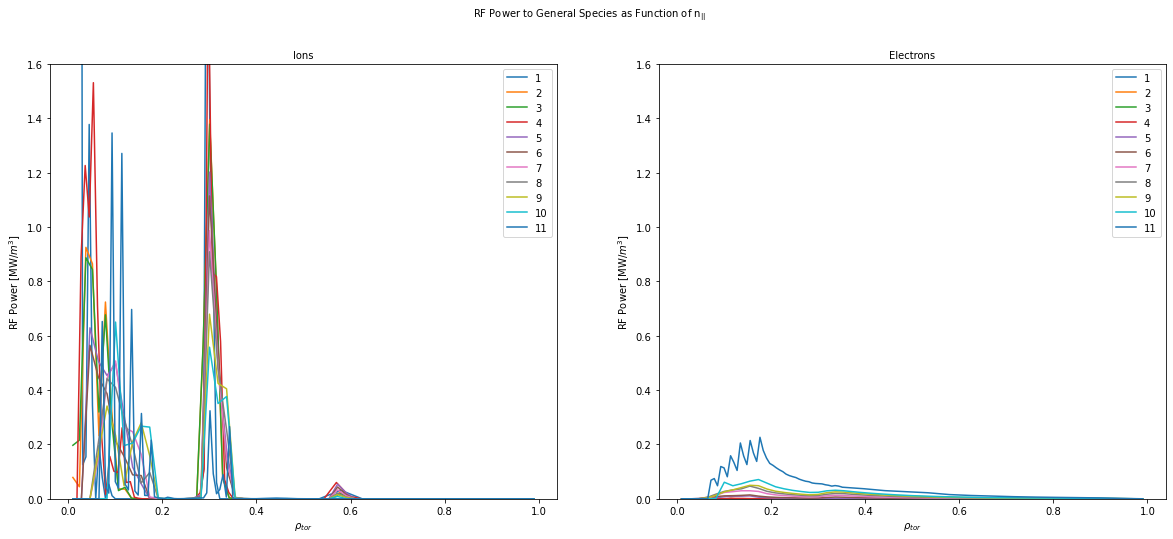

In [10]:
species_index = 0

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(r'RF Power to General Species as Function of n$_{||}$')
fig.set_size_inches(20, 8)

powers_array = np.zeros_like(scan_var_array).tolist()
for i in range(scan_var_array.shape[0]):
    powers_array[i] = cql_nc_array[i].variables['powers'][-1, species_index, :, :]

pwr_RF_to_gen = np.zeros_like(scan_var_array).tolist()
for i in range(scan_var_array.shape[0]):
    pwr_RF_to_gen[i] = powers_array[i][4, :]


for i in range(scan_var_array.shape[0]):
    # if i == 3:
    label = str(scan_var_array[i]) 
    ax1.plot(rya_list[i], pwr_RF_to_gen[i], label=label)
ax1.set_ylim(0, 1.6)
ax1.legend()

ax1.set_xlabel(r'$\rho_{tor}$')
ax1.set_ylabel(r'RF Power [MW/$m^3$]')
ax1.set_title('Ions')


species_index = 1
powers_array = np.zeros_like(scan_var_array).tolist()
for i in range(scan_var_array.shape[0]):
    powers_array[i] = cql_nc_array[i].variables['powers'][-1, species_index, :, :]

pwr_RF_to_gen = np.zeros_like(scan_var_array).tolist()
for i in range(scan_var_array.shape[0]):
    pwr_RF_to_gen[i] = powers_array[i][4, :]

for i in range(scan_var_array.shape[0]):
    #if i == 3:
    label = str(scan_var_array[i]) 
    ax2.plot(rya_list[i], pwr_RF_to_gen[i], label=label)
ax2.set_ylim(0, 1.6)
ax2.legend()

ax2.set_xlabel(r'$\rho_{tor}$')
ax2.set_ylabel(r'RF Power [MW/$m^3$]')
ax2.set_title('Electrons')


RF powers to ions [MW]:  [0.64793793 0.65415247 0.65598761 0.6986487  0.67086904 0.59122859
 0.58021868 0.57050668 0.52864562 0.49864894 0.25893721]
RF powers to electrons [MW]:  [3.63928339e-11 7.47577107e-05 5.94936745e-05 1.02106575e-03
 1.24495279e-02 3.16672985e-02 7.30982315e-02 1.14807794e-01
 1.48258345e-01 1.99185347e-01 4.37839472e-01]


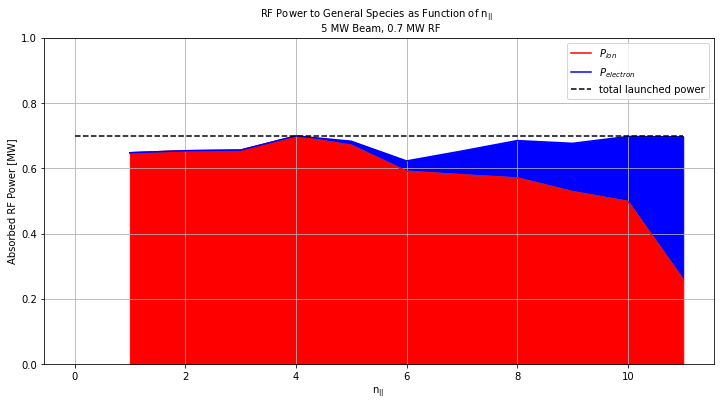

In [11]:
# Area to plot the power partition between species
total_RF_power_ion_array = np.zeros_like(scan_var_array, dtype='float') #np.array([0.0, 0.0, 0.0, 0.0, 0.0])
total_RF_power_e_array = np.zeros_like(scan_var_array, dtype='float') #np.array([0.0, 0.0, 0.0, 0.0, 0.0])
pwr_RF_to_gen_ion_array = np.zeros_like(scan_var_array).tolist()
pwr_RF_to_gen_e_array = np.zeros_like(scan_var_array).tolist()

species_index = 0
for i in range(len(pwr_RF_to_gen_ion_array)):
    pwr_RF_to_gen_ion_array[i] = cql_nc_array[i].variables['powers'][-1, species_index, :, :][4, :]

for i in range(total_RF_power_ion_array.shape[0]):
    total_RF_power_ion_array[i] = np.trapz(pwr_RF_to_gen_ion_array[i].data*dvol_list[i]*(1/100)**3)


species_index = 1
for i in range(len(pwr_RF_to_gen_e_array)):
    pwr_RF_to_gen_e_array[i] = cql_nc_array[i].variables['powers'][-1, species_index, :, :][4, :]

for i in range(total_RF_power_ion_array.shape[0]):
    # if i == 3: # TODO TODO remove this logic!!
    total_RF_power_e_array[i] = np.trapz(pwr_RF_to_gen_e_array[i].data*dvol_list[i]*(1/100)**3)



print('RF powers to ions [MW]: ', total_RF_power_ion_array)
print('RF powers to electrons [MW]: ', total_RF_power_e_array)
total_RF_power_both = total_RF_power_ion_array + total_RF_power_e_array
fig, ax1 = plt.subplots(1, 1)
plt.title(f'RF Power to General Species as Function of {scan_var_type} \n 5 MW Beam, 0.7 MW RF')
factor = 1.2
plt.ylim(0, 1)
fig.set_size_inches(10*factor, 5*factor)
plt.plot(scan_var_array, total_RF_power_ion_array)
#plt.plot(rfpwr_array, total_RF_power_e)
plt.plot(scan_var_array, total_RF_power_ion_array, color='red', label=r'$P_{ion}$')
plt.plot(scan_var_array, total_RF_power_both, color='blue', label=r'$P_{electron}$')
plt.xlabel(scan_var_type)
plt.ylabel('Absorbed RF Power [MW]')
#plt.ylim(0, 1)

plt.fill_between(scan_var_array, total_RF_power_both, total_RF_power_ion_array, color='blue')
plt.fill_between(scan_var_array, total_RF_power_both*0, total_RF_power_ion_array, color='red')
plt.grid()
plt.plot(np.array([0,1,11]), 0.7*np.array([1,1,1]), 'k--', label='total launched power')
plt.legend()
#print(total_RF_power_both[-1])

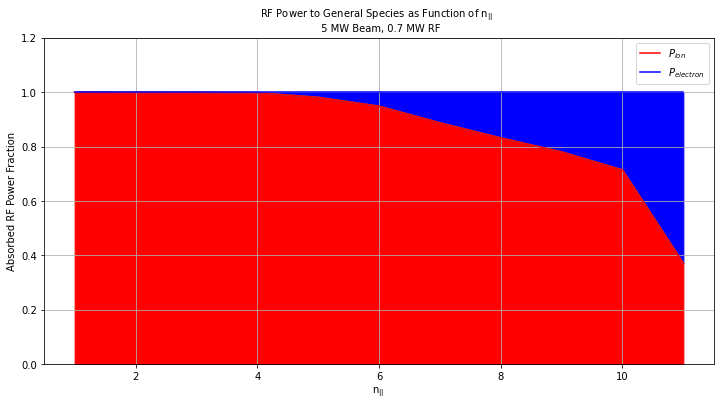

In [12]:
# same plot but fractional power partitioning 
fractional_total_power = total_RF_power_both / total_RF_power_both
fractional_total_RF_power_ion = total_RF_power_ion_array / total_RF_power_both
fractional_total_RF_power_electron = total_RF_power_e_array / total_RF_power_both


fig, ax1 = plt.subplots(1, 1)
plt.title(f'RF Power to General Species as Function of {scan_var_type} \n 5 MW Beam, 0.7 MW RF')
factor = 1.2
plt.ylim(0, 1.2)
fig.set_size_inches(10*factor, 5*factor)
plt.plot(scan_var_array, fractional_total_RF_power_ion)
#plt.plot(rfpwr_array, total_RF_power_e)
plt.plot(scan_var_array, fractional_total_RF_power_ion, color='red', label=r'$P_{ion}$')
plt.plot(scan_var_array, fractional_total_power, color='blue', label=r'$P_{electron}$')
plt.xlabel(scan_var_type)
plt.ylabel('Absorbed RF Power Fraction')
plt.legend()
#plt.ylim(0, 1)

plt.fill_between(scan_var_array, fractional_total_power, fractional_total_RF_power_ion, color='blue')
plt.fill_between(scan_var_array, total_RF_power_both*0, fractional_total_RF_power_ion, color='red')
plt.grid()

0.9985406461743178


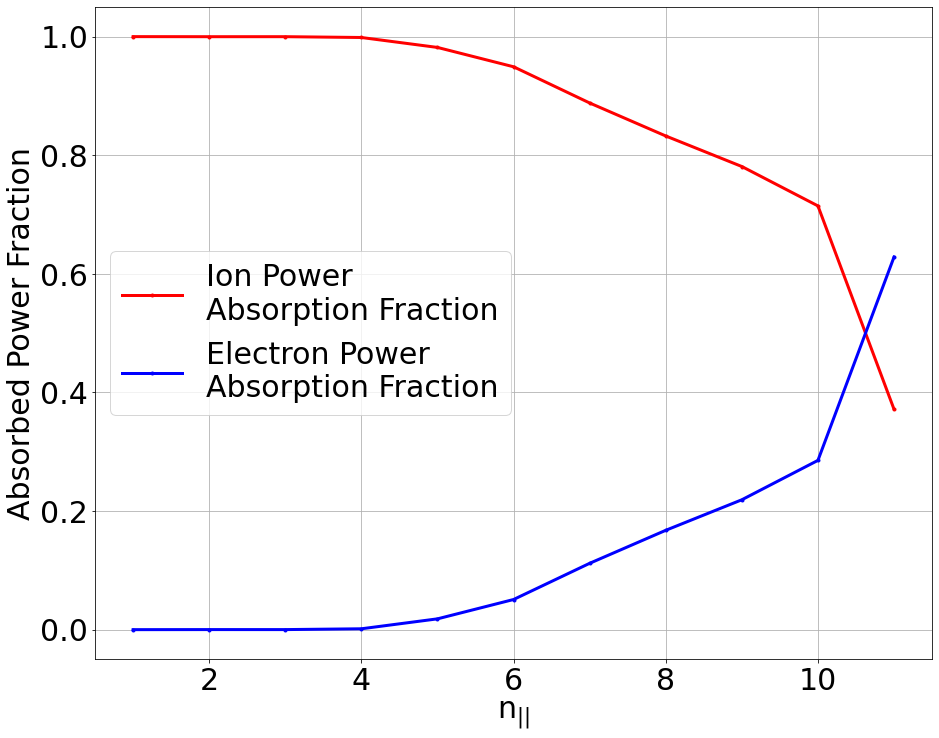

In [16]:
# line graph of above 
plt.figure(figsize=(15,12))
plt.plot(scan_var_array, fractional_total_RF_power_ion, color='red', label='Ion Power \nAbsorption Fraction',marker='.',linewidth=3)
plt.plot(scan_var_array, fractional_total_RF_power_electron, color='blue', label='Electron Power \nAbsorption Fraction',marker='.',linewidth=3)
plt.grid()
plt.xlabel(r'n$_{||}$', fontsize=30)
plt.ylabel('Absorbed Power Fraction', fontsize=30)
plt.legend(fontsize=30, loc='center left')
plt.xticks(fontsize=30)  # Set x-axis tick label font size
plt.yticks(fontsize=30)  # Set y-axis tick label font size
print(fractional_total_RF_power_ion[3])

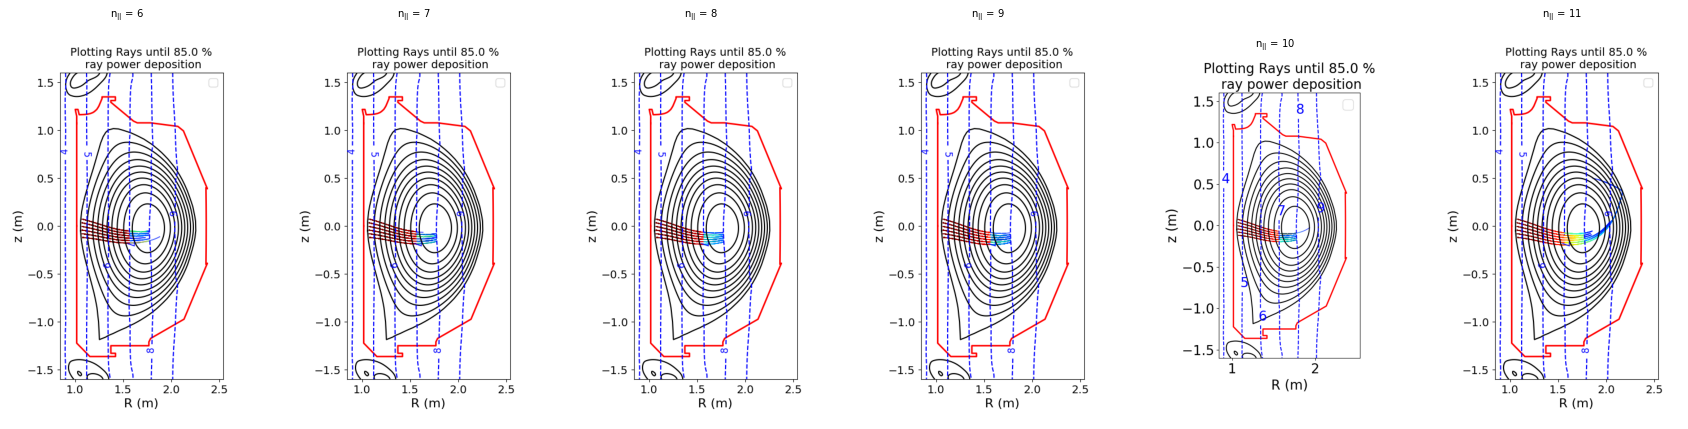

In [14]:
%matplotlib inline
plt.rc('figure', labelsize=52)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
ax1.imshow(mpimg.imread('rays_npar_6.png'))
ax2.imshow(mpimg.imread('rays_npar_7.png'))
ax3.imshow(mpimg.imread('rays_npar_8.png'))
ax4.imshow(mpimg.imread('rays_npar_9.png'))
ax5.imshow(mpimg.imread('rays_npar_10.png'))
ax6.imshow(mpimg.imread('rays_npar_11.png'))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')

ax1.set_title(r'n$_{||}$ = 6')
ax2.set_title(r'n$_{||}$ = 7')
ax3.set_title(r'n$_{||}$ = 8')
ax4.set_title(r'n$_{||}$ = 9')
ax5.set_title(r'n$_{||}$ = 10')
ax6.set_title(r'n$_{||}$ = 11')

fig.set_size_inches(30, 30)

plt.show()

In [15]:
# plot the energetic particles over rho to easily compare between cases. 

def plot_energetic_ion_density_versus_rho(min_E, f, species_index, beam_label):
    minEnergy = 2 # minimum energy for plotting

    #index of that minimum energy in enerkev
    #this index is also the index for the corresponding velocity
    minEnergyIndex = np.where(enerkev < minEnergy)[0][-1]
    #distribution function for energetic particles (ions)
    energeticF = f[species_index, :,minEnergyIndex:,:]#f[0, :,minEnergyIndex:,:]

    # begin integrating over velocity space 
    energeticF_integOverPitch = np.zeros((len(rya), len(enerkev[minEnergyIndex:])))

    # loop over r/a. At each r/a, integrate over all pitch angle. 
    for rhoIndex in range(len(rya)):
        #this is the angular part of the spherical jacobian
        integOverPitch = 2*np.pi*np.trapz(energeticF[rhoIndex,:]*np.sin(pitchAngleMesh[rhoIndex]), pitchAngleMesh[rhoIndex], axis = 1)
        energeticF_integOverPitch[rhoIndex,:] = integOverPitch
        
    relevantEnergies = enerkev[minEnergyIndex:]
    relevantVels = normalizedVel[minEnergyIndex:]
    energeticDensity = np.zeros((len(rya), len(relevantEnergies)-1))
    #the energies at which the values of energeticDensity are centered
    energyCenters = (relevantEnergies[1:] + relevantEnergies[:-1])/2

    # Ion density versus r/a. Integrated over all energies. 

    energeticDensity_1D = np.zeros(len(rya))
    E_idx = np.argmin(np.abs(min_E - enerkev))

    #this is the radial part of the spherical jacobian
    energeticDensity_1D = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,E_idx:]*relevantVels[E_idx:]**2,
        relevantVels[E_idx:]))

    energeticDensity_1D = energeticDensity_1D*1e6 # convert to m^-3
    plt.yscale('log')
    plt.ylim([1e0, 1e19])
    plt.plot(rya, energeticDensity_1D, label=beam_label)
    plt.xlabel(r'$\rho_{tor}$')
    plt.ylabel(f'Ion Density for E_ion > {min_E} keV' + r' [$m^{-3}$]')


for i in range(len(f_array)):
    label = r'$n_{||}$ = ' + str(scan_var_array[i]) 
    plot_energetic_ion_density_versus_rho(min_E=200, f=f_array[i], species_index=0, beam_label=label)


plt.legend()


NameError: name 'enerkev' is not defined

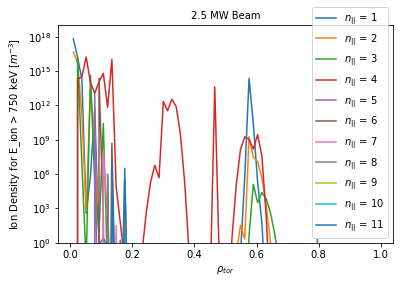

In [ ]:

for i in range(len(f_array)):
    label = r'$n_{||}$ = ' + str(scan_var_array[i]) 
    plot_energetic_ion_density_versus_rho(min_E=750, f=f_array[i], species_index=0, beam_label=label)
plt.title('2.5 MW Beam')
plt.legend()

Text(0, 0.5, 'Absorbed Beam Power Density $MW/m^3$')

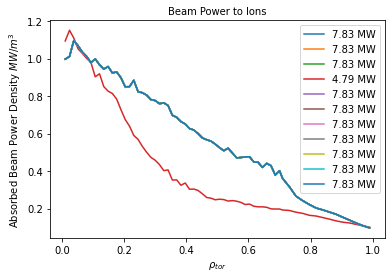

In [ ]:
# NB power area 
species_index = 0
pwr_beam_to_gen_array = np.zeros_like(scan_var_array).tolist()
for i in range(len(pwr_beam_to_gen_array)):
    pwr_beam_to_gen_array[i] = cql_nc_array[i].variables['powers'][-1, species_index, :, :][5, :]


for i in range(len(pwr_beam_to_gen_array)):
    beam_power = np.trapz(pwr_beam_to_gen_array[i]*dvol*(1/100)**3)
    label = str(round(beam_power, 2)) + ' MW'
    plt.plot(rya, pwr_beam_to_gen_array[i], label=label)

plt.legend()
plt.title('Beam Power to Ions')
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Absorbed Beam Power Density $MW/m^3$')

5


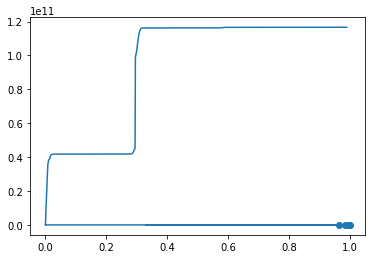

In [ ]:
# delete this area. Just checking I am thinknig about these rays correctly. 
from scipy import signal
find_peaks = signal.find_peaks
radialVariable = (np.copy(cqlrf_nc_array[1].variables["spsi"]))
delpwr= np.copy(cqlrf_nc_array[1].variables["delpwr"])
bounceRho = .96 
ray = 10
peakIndices, _ = find_peaks(radialVariable[ray, :], height = bounceRho)
offset = 0
relevantIndices = peakIndices#[peakIndices > offset]

plt.plot(radialVariable[ray, :], delpwr[ray, :])
plt.scatter(radialVariable[ray, peakIndices], delpwr[ray, peakIndices])
print(len(relevantIndices))
#print(delpwr[])

In [ ]:
# Calculate SPA for different beam powers 
from scipy import signal
find_peaks = signal.find_peaks
# Calculate SPA for different beam powers 
from scipy import signal
find_peaks = signal.find_peaks
def getSPA(cqlrf_nc):
    """
    Finds single pass absorbtion using 
    1) energy at reflection point if ray is reflected
    2) assume all ray energy deposited if not reflected 
    Jacob fixed bug ignoring rays that did not reflect in SPA calculation 
    """
    radialVariable = (np.copy(cqlrf_nc.variables["spsi"]))
    delpwr= np.copy(cqlrf_nc.variables["delpwr"])


    #initialize SPA to zero. 
    averageSPA = 0
    bounceRho = .96  # if the ray turns after rho = 0.96, consider it reflected
   
    #fig,ax = plt.subplots()
    offset = 1     # reject turning points at eary times 
    ticker = 0
    for i in range(len(delpwr)):
        peakIndices, _ = find_peaks(radialVariable[i], height = bounceRho)
        relevantIndices = peakIndices[peakIndices > offset]
        
        #print(len(relevantIndices))
        if len(relevantIndices) >= 1:
            bounceIndex = relevantIndices[0]
            SPA = 1-delpwr[i][bounceIndex]/delpwr[i][0]
            averageSPA += SPA
            ticker = ticker + 1 
        elif len(relevantIndices) == 0:
            SPA = 1
            averageSPA += SPA
            #wr  = cqlrf_nc.variables["wr"][:] #major radius of the ray at each point along the trace
            #wz  = cqlrf_nc.variables["wz"][:]
            #plt.plot(wr[i, :], wz[i, :])
            #print(f'ray={i}')
            #break

    #print(f'ticker: {ticker}')  
    averageSPA /= len(delpwr)
    print(f"average SPA: {averageSPA}")
    print(f'% of rays reflected: {ticker*100/len(delpwr)} %')
    return averageSPA

In [ ]:
SPA_array = np.zeros_like(scan_var_array)#np.array([0.0, 0.0, 0.0, 0.0, 0.0])
for i in range(SPA_array.shape[0]):
    SPA_array[i] = getSPA(cqlrf_nc_array[i])


average SPA: 0.9920764450067495
% of rays reflected: 100.0 %
average SPA: 0.9970273921954802
% of rays reflected: 100.0 %
average SPA: 0.9924381223348434
% of rays reflected: 100.0 %
average SPA: 0.9955655547012073
% of rays reflected: 100.0 %
average SPA: 0.9799771685263742
% of rays reflected: 100.0 %
average SPA: 0.9899324057918444
% of rays reflected: 100.0 %
average SPA: 0.969905024031803
% of rays reflected: 100.0 %
average SPA: 0.9553832790795568
% of rays reflected: 100.0 %
average SPA: 0.9604456211397957
% of rays reflected: 100.0 %
average SPA: 0.9225894569519008
% of rays reflected: 100.0 %
average SPA: 0.9104964644776381
% of rays reflected: 100.0 %


Text(0, 0.5, 'SPA for 10 MW Beam')

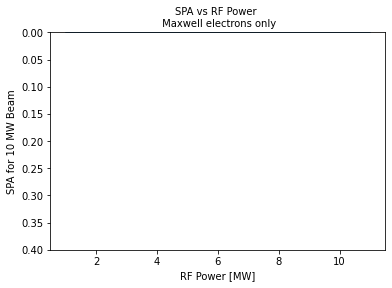

In [ ]:
plt.ylim((0.4, 1.1*max(SPA_array)))
plt.plot(scan_var_array, SPA_array)
plt.title(f'SPA vs RF Power \n Maxwell electrons only')
plt.xlabel('RF Power [MW]')
plt.ylabel('SPA for 10 MW Beam')

FileNotFoundError: [Errno 2] No such file or directory: 'rays_rfpwr0_5.png'

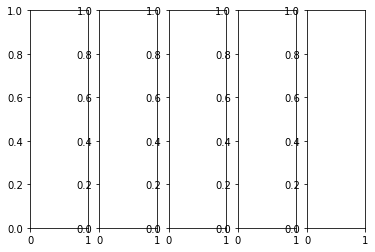

In [ ]:
%matplotlib inline
import matplotlib
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#plt.rcParams.update({'font.size': 30})
ax1.imshow(mpimg.imread('rays_rfpwr0_5.png'))
ax2.imshow(mpimg.imread('rays_rfpwr0_55.png'))
ax3.imshow(mpimg.imread('rays_rfpwr0_6.png'))
ax4.imshow(mpimg.imread('rays_rfpwr0_65.png'))
ax5.imshow(mpimg.imread('rays_rfpwr0_7.png'))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')

ax1.set_title(f'RF Power = 0.5 MW \n Beam Power: 5 MW \n SPA: {round(SPA_array[0], 3)}')
ax2.set_title(f'RF Power = 0.55 MW \n Beam Power: 5 MW \n SPA: {round(SPA_array[1], 3)}')
ax3.set_title(f'RF Power = 0.6 MW \n Beam Power: 5 MW \n SPA: {round(SPA_array[2], 3)}')
ax4.set_title(f'RF Power = 0.65 MW \n Beam Power: 5 MW \n SPA: {round(SPA_array[3], 3)}')
ax5.set_title(f'RF Power = 0.7 MW \n Beam Power: 5 MW \n SPA: {round(SPA_array[4], 3)}')

# ax1.set_title('Beam Power = 0 MW')
# ax2.set_title('Beam Power = 2.5 MW')
# ax3.set_title('Beam Power = 5 MW')
# ax4.set_title('Beam Power = 7.5 MW')
# ax5.set_title('Beam Power = 10 MW')

fig.set_size_inches(30, 30)

plt.show()

60


(100.92021445299184,
 231.3989784784996,
 -119.11393317897686,
 109.29700017162483)

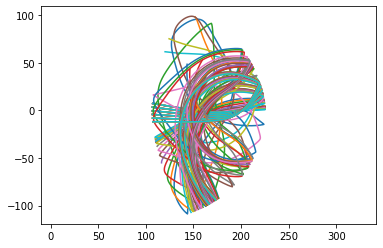

In [ ]:
# Ray traces 

wr  = cqlrf_nc_array[1].variables["wr"][:] #major radius of the ray at each point along the trace
wz  = cqlrf_nc_array[1].variables["wz"][:]

wr[wr ==0] = np.nan
wz[wz==0] = np.nan
print(len(wr))
for i_ray in range(len(wr)):
    plt.plot(wr[i_ray, :], wz[i_ray, :])

plt.axis('equal')

In [ ]:
# wr  = cqlrf_nc_0_55.variables["wr"][:] #major radius of the ray at each point along the trace
# wz  = cqlrf_nc_0_55.variables["wz"][:]
# radialVariable = (np.copy(cqlrf_nc_0_55.variables["spsi"]))
# delpwr= np.copy(cqlrf_nc_0_55.variables["delpwr"])

# ray_idx = 0
# plt.plot(radialVariable[ray_idx], delpwr[ray_idx])